# Работа с уменьшенным датасетом Omniglot

---



# Загрузка уменьшенного датасета Omniglot

Загрузка датасета

In [1]:
from sklearn.metrics import accuracy_score
from google.colab import drive
import numpy as np
import os

drive.mount('/content/drive')

PATH = 'drive/My Drive/Few-Shot-Learning/Omniglot-data-set'

RANDOM_STATE = 17
NUMBER_OF_CLASSES = 100

X_train_r = np.resize(np.loadtxt(os.path.join(PATH, 'train_images.txt'), dtype=np.uint8), (14 * NUMBER_OF_CLASSES, 1, 105, 105))
y_train_r = np.resize(np.loadtxt(os.path.join(PATH, 'train_labels.txt'), dtype='str'), (14 * NUMBER_OF_CLASSES))

X_test_r = np.resize(np.loadtxt(os.path.join(PATH, 'test_images.txt'), dtype=np.uint8), (6 * NUMBER_OF_CLASSES, 1, 105, 105))
y_test_r = np.resize(np.loadtxt(os.path.join(PATH, 'test_labels.txt'), dtype='str'), (6 * NUMBER_OF_CLASSES))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Определение трансформации

In [16]:
!pip install -q -U albumentations
import albumentations as A

from albumentations.pytorch import ToTensorV2

transform = A.Compose([A.SmallestMaxSize(max_size=105),
                       A.CenterCrop(height=84, width=84),
                       A.Normalize(mean=(0.5), std=(0.5)),
                       ToTensorV2(),])

Определение тензоров

In [17]:
import torch

train_images = torch.stack([transform(image=x[0])["image"] for x in X_train_r]).float()
test_images = torch.stack([transform(image=x[0])["image"] for x in X_test_r]).float()

classes = [y_train_r[14 * i] for i in range(NUMBER_OF_CLASSES)]

train_labels = torch.from_numpy(np.array([[i] for i in range(NUMBER_OF_CLASSES) for _ in range(14)])).long()
test_labels = torch.from_numpy(np.array([[i] for i in range(NUMBER_OF_CLASSES) for _ in range(6)])).long()

Определение вспомогательной функции для подготовки выборки

In [18]:
import random

def shuffle_tensor(tensor, batch_size):
    random.shuffle(tensor)

    images, labels = zip(*tensor)

    images = torch.stack(images[:])
    labels = torch.stack(labels[:])

    images = images.view(14 * NUMBER_OF_CLASSES // batch_size, batch_size, 1, 84, 84).float()
    labels = labels.view(14 * NUMBER_OF_CLASSES // batch_size, batch_size).long()

    return list(zip(images, labels))
    

def shuffle_tensor_tuple(tensor, batch_size):
    random.shuffle(tensor)

    images, labels = zip(*tensor)

    images = torch.stack(images[:])
    labels = torch.stack(labels[:])

    images = images.view(14 * NUMBER_OF_CLASSES // batch_size // 2, 2, batch_size, 1, 84, 84).float()
    labels = labels.view(14 * NUMBER_OF_CLASSES // batch_size // 2, 2, batch_size).long()

    return list(zip(images, labels))

# Визуализация датасета Omniglot (уменьшенный датасет)

label: Alphabet_of_the_Magi_01


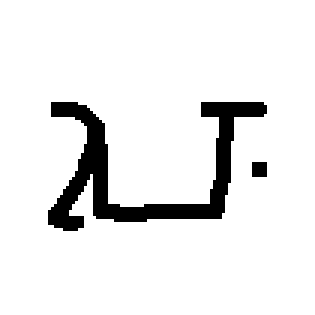

In [5]:
from PIL import Image

digit_number = 0

image = Image.fromarray(X_train_r[digit_number].reshape(105, 105), mode='P')

print('label: {}'.format(y_train_r[digit_number]))
display(image.resize((315, 315)))

# Использование сиамской нейронной сети для решения задачи классификации рукописных символов (уменьшенный датасет)

Создание сиамской нейронной сети

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.bnorm2 = nn.BatchNorm2d(32)
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(32 * 19 * 19, 1000)
        self.fc2 = nn.Linear(1000, 30)

    def forward_once(self, x):
        x_out = F.relu(self.bnorm1(self.pool(self.conv1(x))))
        x_out = F.relu(self.bnorm2(self.pool(self.conv2(x_out))))
        x_out = x_out.view(-1, 32 * 19 * 19)
        x_out = F.relu(self.drop(self.fc1(x_out)))
        x_out = self.fc2(x_out)
        return x_out

    def forward(self, x_1, x_2):
        return self.forward_once(x_1), self.forward_once(x_2)

Определение функции потерь

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()

        self.margin = margin

    def forward(self, x_1, x_2, y):
        diff = x_1 - x_2
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)

        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x_1.size()[0]

        return loss

Обучение сиамской нейронной сети

In [ ]:
import torch.optim as optim

net = Net().cuda()

criterion = ContrastiveLoss(margin=100)
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

for iteration in range(5000):
    trainset = shuffle_tensor_tuple(list(zip(train_images, train_labels)), 350)

    for data in trainset:
        images, labels = data[0].cuda(), data[1].cuda()

        optimizer.zero_grad()

        labels_pred = net(*images)
        loss = criterion(*labels_pred, (labels[0] == labels[1]).type(torch.uint8))

        loss.backward()
        optimizer.step()

Использование сиамской нейронной сети

In [22]:
def distance(x_1, x_2):
    return torch.sqrt(torch.sum(torch.pow(x_1 - x_2, 2), 1))


predicted_s = []

net.eval()

for image in test_images:
    predicted_s.append(None)
    min_dist = None

    encoded = net.forward_once(image.unsqueeze(0).cuda())
    trainset = shuffle_tensor(list(zip(train_images, train_labels)), 350)

    for images, labels in trainset:
        dists = distance(encoded, net.forward_once(images.cuda()))
        index = dists.argmin()

        if min_dist is None or dists[index] < min_dist:
            predicted_s[-1] = labels[index]
            min_dist = dists[index]

Вычисление метрик

In [23]:
print('accuracy {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted_s)))

accuracy 0.762


# Сравнение результатов работы сиамской нейронной сетей с рассмотренными ранее нейронными сетями для датасета Omniglot (уменьшенный датасет)

In [24]:
from sklearn.metrics import accuracy_score

print('Siamese Neural network accuracy: {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted_s)))

Siamese Neural network accuracy: 0.762


Использование кардинально нового подхода обучения нейронной сети в качестве энкодера на данном относительно небольшом датасете позволило достичь высоких результатов без применения аугментации. При сравнении с обычными нейронными сетями данный подход позволил значительно поднять метрику точности (на 15-25%). Из минусов можно выделить сравнительно большое как время обучения, так и время для предсказания. Если сравнивать применение модели сиамских нейронных сетей с обычными нейронными сетями, но с применением аугментации, то данная модель смогла достичь результатов полносвязной нейронной сети, но до результата сверточной нейронной сети ей все же еще далеко. Седует отметить громадное число параметров архитектуры сети, которые хоть и были настроены на многих экспериментах, но вероятно могут быть настроены лучше и итогово догнать сверточную нейронную сеть по метрике точности.